In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
data_set_dir = 'drive/MyDrive/ml-latest-small/'
ratings_csv = data_set_dir + 'ratings.csv'
movies_csv = data_set_dir + 'movies.csv'

ratings_df = pd.read_csv(ratings_csv)
movies_df = pd.read_csv(movies_csv)

In [ ]:
ratings_df.shape

(100836, 4)

In [ ]:
df = ratings_df.merge(movies_df, on='movieId').sort_values('userId')
df = df.drop(columns=['timestamp'])

In [ ]:
X = df[['userId','movieId']]
X

,userId,movieId
0,1,1
12117,1,2389
12126,1,2395
12182,1,2406
776,1,70
...,...,...
84152,610,51709
26937,610,589
69808,610,66097
69820,610,71464


In [ ]:
y =  df['rating'] - np.mean(df['rating'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[['userId','movieId']], y, test_size=0.2, random_state=42)

Using Keras and embedding to build a model

In [ ]:
hidden_units = (32,4)
movie_embedding_size = 8
user_embedding_size = 8

In [ ]:
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
# Concatenate the embeddings (and remove the useless extra dimension)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

In [ ]:
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.summary(line_length=88)

Model: "model"
________________________________________________________________________________________
 Layer (type)                Output Shape       Param #   Connected to                  
 user_id (InputLayer)        [(None, 1)]        0         []                            
                                                                                        
 movie_id (InputLayer)       [(None, 1)]        0         []                            
                                                                                        
 user_embedding (Embedding)  (None, 1, 8)       4888      ['user_id[0][0]']             
                                                                                        
 movie_embedding (Embedding)  (None, 1, 8)      1548880   ['movie_id[0][0]']            
                                                                                        
 concatenate (Concatenate)   (None, 1, 16)      0         ['user_embedding[0][0]',      
      

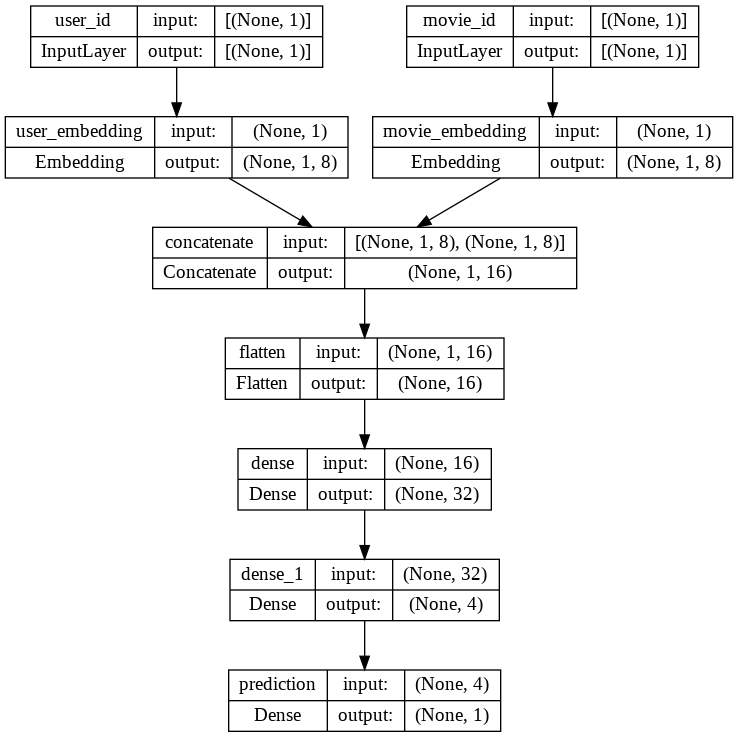

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
model.compile(
    # Technical note: when using embedding layers, I highly recommend using one of the optimizers
    # found  in tf.train: https://www.tensorflow.org/api_guides/python/train#Optimizers
    # Passing in a string like 'adam' or 'SGD' will load one of keras's optimizers (found under 
    # tf.keras.optimizers). They seem to be much slower on problems like this, because they
    # don't efficiently handle sparse gradient updates.
    tf.optimizers.Adam(0.01),
    # tf.train.Adam(0.005),
    loss='MSE',
    metrics=['MAE'],
)

In [ ]:
history = model.fit(
    [X_train.userId, X_train.movieId],
    y_train,
    batch_size=5000,
    epochs=20,
    verbose=1,
    validation_split=.05,
);

Epoch 1/20
3801/3801 [==============================] - 217s 56ms/step - loss: 0.7304 - MAE: 0.6514 - val_loss: 0.6946 - val_MAE: 0.6392
Epoch 2/20
3801/3801 [==============================] - 198s 52ms/step - loss: 0.6678 - MAE: 0.6212 - val_loss: 0.6764 - val_MAE: 0.6283
Epoch 3/20
3801/3801 [==============================] - 183s 48ms/step - loss: 0.6400 - MAE: 0.6075 - val_loss: 0.6587 - val_MAE: 0.6171
Epoch 4/20
3801/3801 [==============================] - 179s 47ms/step - loss: 0.6203 - MAE: 0.5977 - val_loss: 0.6556 - val_MAE: 0.6194
Epoch 5/20
3801/3801 [==============================] - 188s 50ms/step - loss: 0.6073 - MAE: 0.5910 - val_loss: 0.6492 - val_MAE: 0.6105
Epoch 6/20
3801/3801 [==============================] - 189s 50ms/step - loss: 0.5984 - MAE: 0.5864 - val_loss: 0.6486 - val_MAE: 0.6091
Epoch 7/20
3801/3801 [==============================] - 183s 48ms/step - loss: 0.5917 - MAE: 0.5829 - val_loss: 0.6473 - val_MAE: 0.6117
Epoch 8/20
3801/3801 [===================

Mean Absolute Error plot

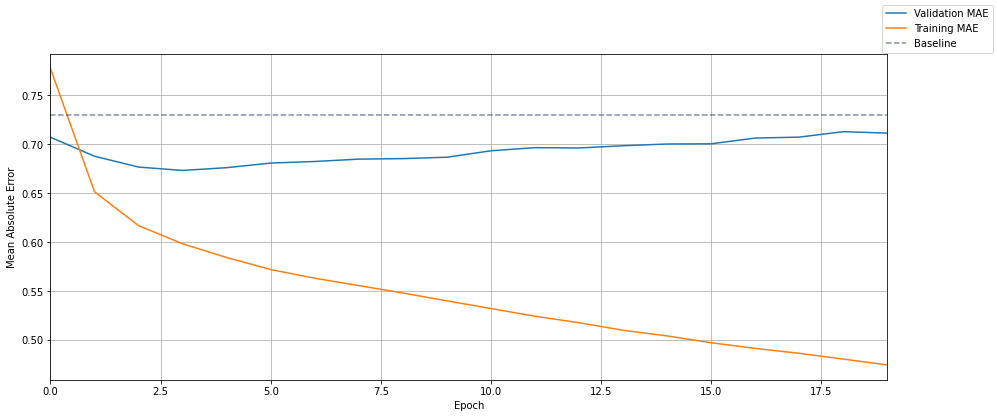

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_MAE'], label='Validation MAE')
ax.plot(history.epoch, history.history['MAE'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

In [ ]:
y_pred = model.predict([X_test.userId, X_test.movieId]) 

631/631 [==============================] - 1s 1ms/step


In [ ]:
metrics.mean_absolute_error(y_test, y_pred)

0.7164772830898174

In [ ]:
new_df = df[df["userId"]==4]
new_df.sort_values(by = ['rating'], ascending = False).head()

,userId,movieId,rating,title,genres
23713,4,3365,5.0,"Searchers, The (1956)",Drama|Western
23419,4,2926,5.0,Hairspray (1988),Comedy|Drama
11105,4,2078,5.0,"Jungle Book, The (1967)",Animation|Children|Comedy|Musical
22814,4,2599,5.0,Election (1999),Comedy
22802,4,2583,5.0,Cookie's Fortune (1999),Comedy|Drama


In [ ]:
X_new = new_df[['userId','movieId']]

In [ ]:
X_new.merge(movies_df, on='movieId')

,userId,movieId,title,genres
0,4,1094,"Crying Game, The (1992)",Drama|Romance|Thriller
1,4,1103,Rebel Without a Cause (1955),Drama
2,4,1179,"Grifters, The (1990)",Crime|Drama|Film-Noir
3,4,1183,"English Patient, The (1996)",Drama|Romance|War
4,4,1188,Strictly Ballroom (1992),Comedy|Romance
...,...,...,...,...
211,4,3508,"Outlaw Josey Wales, The (1976)",Action|Adventure|Drama|Thriller|Western
212,4,3481,High Fidelity (2000),Comedy|Drama|Romance
213,4,3851,I'm the One That I Want (2000),Comedy
214,4,3408,Erin Brockovich (2000),Drama


In [ ]:
y_new = new_df[['rating']]

In [ ]:
original_movie_list = movies_df['movieId']

In [ ]:
l_guy = set(X_new["movieId"])
l_all = set(original_movie_list)
l_test = l_all - l_guy

In [ ]:
df_new = pd.DataFrame()
df_new["movieId"] = list(l_test)
df_new['userId'] = 4
df_new

,movieId,userId
0,1,4
1,2,4
2,3,4
3,4,4
4,5,4
...,...,...
9521,163809,4
9522,32743,4
9523,98279,4
9524,65514,4


In [ ]:
y_new_guy = model.predict([df_new['userId'], df_new["movieId"]])

298/298 [==============================] - 0s 1ms/step


In [ ]:
y_new_guy

array([[-0.25433585],
       [-1.1255326 ],
       [-1.528007  ],
       ...,
       [ 0.94990087],
       [-0.6530261 ],
       [-1.0443072 ]], dtype=float32)

In [ ]:
df_new['rating'] = y_new_guy


In [ ]:
df_new1 = df_new.sort_values(by = ["rating"] , ascending = False)

In [ ]:
np.mean(df['rating'])

3.501556983616962

In [ ]:
df_predicted_movies = df_new1.merge(movies_df, on='movieId').head()

In [ ]:
df_predicted_movies

,movieId,userId,rating,title,genres
0,47736,4,1.899158,"Chump at Oxford, A (1940)",Comedy
1,149350,4,1.880095,Lumberjack Man (2015),Comedy|Horror
2,69211,4,1.867170,Boy Eats Girl (2005),Comedy|Horror
3,132153,4,1.827228,Buzzard (2015),Comedy|Drama|Horror
4,136353,4,1.823526,Scooby-Doo! and the Loch Ness Monster (2004),Animation|Children|Comedy


USING DIFFERENT HIDDEN LAYERS

In [ ]:
hidden_units = (32,4)
movie_embedding_size = 8
user_embedding_size = 8

In [ ]:
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
# Concatenate the embeddings (and remove the useless extra dimension)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.summary(line_length=88)

Model: "model_3"
________________________________________________________________________________________
 Layer (type)                Output Shape       Param #   Connected to                  
 user_id (InputLayer)        [(None, 1)]        0         []                            
                                                                                        
 movie_id (InputLayer)       [(None, 1)]        0         []                            
                                                                                        
 user_embedding (Embedding)  (None, 1, 8)       4888      ['user_id[0][0]']             
                                                                                        
 movie_embedding (Embedding)  (None, 1, 8)      1548880   ['movie_id[0][0]']            
                                                                                        
 concatenate_3 (Concatenate)  (None, 1, 16)     0         ['user_embedding[0][0]',      
    

In [ ]:
model.compile(
    # Technical note: when using embedding layers, I highly recommend using one of the optimizers
    # found  in tf.train: https://www.tensorflow.org/api_guides/python/train#Optimizers
    # Passing in a string like 'adam' or 'SGD' will load one of keras's optimizers (found under 
    # tf.keras.optimizers). They seem to be much slower on problems like this, because they
    # don't efficiently handle sparse gradient updates.
    tf.optimizers.Adam(0.005),
    # tf.train.Adam(0.005),
    loss='MSE',
    metrics=['MAE'],
)

In [ ]:
history = model.fit(
    [X_train.userId, X_train.movieId],
    y_train,
    batch_size=5000,
    epochs=20,
    verbose=1,
    validation_split=.05,
);

Epoch 1/20
16/16 [==============================] - 1s 21ms/step - loss: 1.0065 - MAE: 0.7949 - val_loss: 0.8819 - val_MAE: 0.7278
Epoch 2/20
16/16 [==============================] - 0s 14ms/step - loss: 0.7547 - MAE: 0.6657 - val_loss: 0.7798 - val_MAE: 0.6895
Epoch 3/20
16/16 [==============================] - 0s 14ms/step - loss: 0.6666 - MAE: 0.6246 - val_loss: 0.7673 - val_MAE: 0.6829
Epoch 4/20
16/16 [==============================] - 0s 13ms/step - loss: 0.6357 - MAE: 0.6077 - val_loss: 0.7656 - val_MAE: 0.6813
Epoch 5/20
16/16 [==============================] - 0s 14ms/step - loss: 0.6177 - MAE: 0.5968 - val_loss: 0.7656 - val_MAE: 0.6783
Epoch 6/20
16/16 [==============================] - 0s 12ms/step - loss: 0.6046 - MAE: 0.5889 - val_loss: 0.7618 - val_MAE: 0.6764
Epoch 7/20
16/16 [==============================] - 0s 13ms/step - loss: 0.5940 - MAE: 0.5821 - val_loss: 0.7599 - val_MAE: 0.6746
Epoch 8/20
16/16 [==============================] - 0s 13ms/step - loss: 0.5827 - M

In [ ]:
y_pred = model.predict([X_test.userId, X_test.movieId]) 

631/631 [==============================] - 1s 863us/step


In [ ]:
metrics.mean_absolute_error(y_test, y_pred)

0.7146836212461919

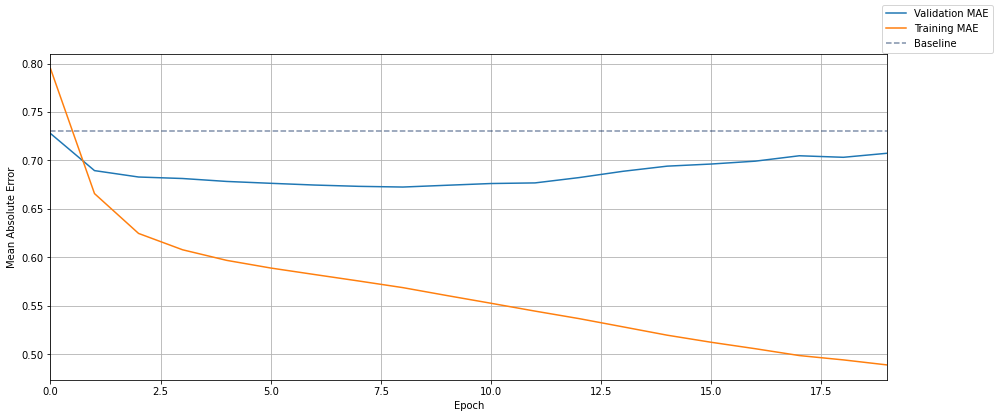

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_MAE'], label='Validation MAE')
ax.plot(history.epoch, history.history['MAE'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

# New User

Recommending movie to new users by mapping them to existing users

In [ ]:
new_user_ratings = {59315:5, 88140: 4, 106072:3, 122892:3.5, 122904:5}
# sorted_new_user_ratings = list(new_user_ratings.items()).sort(key = lambda item: item[1])

SImilar user

In [ ]:
new_user_ratings.keys()

dict_keys([59315, 88140, 106072, 122892, 122904])

In [ ]:
genres_df = movies_df['genres'].str.split('|', expand=True)


In [ ]:
genres = genres_df[0].unique()
type(genres)

numpy.ndarray

In [ ]:
from scipy import stats

In [ ]:
user_genre = pd.DataFrame(columns = ['userId','genre'])

user_genre['userId'] = df['userId'].unique()
# avg_rating
# for i in range()
user_genre.head()

,userId,genre
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [ ]:
temp = []
for userId in user_genre['userId']:

  r = df[df['userId']==userId]
  user1_genres_count = dict()
  user1_genre = dict()
  for index, row in r.iterrows():
    user_genres = row['genres'].split('|')
    for ug in user_genres:
      if ug not in user1_genres_count:
        user1_genres_count[ug] = 0
        user1_genre[ug] = []
      user1_genres_count[ug] += 1
      
      # user1_genre[user_genre] = user1_genre[user_genre] * (user1_genres_count[user_genre] - 1)/(user1_genres_count[user_genre]) + 1/user1_genres_count[user_genre] * row['rating']
      user1_genre[ug].append(row['rating'])
  for g in user1_genre:
    mo, f = stats.mode(user1_genre[g])
    user1_genre[g] = mo*f

  temp.append(max(user1_genre.items(), key = lambda item : item[1][0])[0])

user_genre['genre'] = temp

user_genre.head()

  

  

  

,userId,genre
0,1,Adventure
1,2,Drama
2,3,Sci-Fi
3,4,Drama
4,5,Drama


In [ ]:
new_user_ratings = {59315:5, 88140: 4, 106072:5, 122892:4, 122904:5}
new_user_genre = 'Action'

In [ ]:
intermediate_users = user_genre[user_genre['genre']==new_user_genre].userId.to_list()

In [ ]:
n_count = []
n_rating = []
for user in intermediate_users:
  count = 0
  user_rating = 0
  checking = df[df['userId']==user]

  for i in list(new_user_ratings.keys()):
    if i in checking['movieId'].tolist():
      count = count + 1
      user_rating = user_rating + int(checking[checking['movieId'] == i].rating)
  n_count.append(count)
  n_rating.append(user_rating)
  


      


In [ ]:
nearest_users = []
nearest_users_rating = []
index_pos = 0
while True:
  try:
      # Search for item in list from indexPos to the end of list
      index_pos = n_count.index(5, index_pos)
      # Add the index position in list
      nearest_users.append(intermediate_users[index_pos])
      nearest_users_rating.append(n_rating[index_pos])

      index_pos += 1
  except ValueError as e:
      break

In [ ]:
nearest_users

[21, 73, 249, 380, 534, 596]

In [ ]:
nearest_users_rating

[16, 22, 20, 24, 19, 17]

In [ ]:
nearest_users[np.argmin(abs(np.array(nearest_users_rating) - sum(new_user_ratings.values())))]

73

In [ ]:
user_genre.genre.unique()

array(['Adventure', 'Drama', 'Sci-Fi', 'Action', 'Comedy', 'Romance',
       'Horror', 'Children', 'Thriller', 'Crime', 'Animation', 'Fantasy',
       'IMAX'], dtype=object)